In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from glob import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle
import torch

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../yolov5/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML
from sahi.model import Yolov5DetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from ensemble_boxes import weighted_boxes_fusion

import albumentations as A

from IPython.display import Image
from matplotlib import animation, rc
rc('animation', html='jshtml')

# Load Data

In [52]:
cv_scheme = 'v2'
INPUT_DIR = Path("../../data/tensorflow-great-barrier-reef/")
df = pd.read_csv(INPUT_DIR / "train.csv")
if cv_scheme == "video_id":
    df['fold'] = df['video_id']
elif cv_scheme == "v2":
    folds = util.load_pickle("../input/fold_test_2.pkl")
    df["fold"] = df["sequence"].apply(lambda x: folds[x])
    
highFP_df = pd.read_csv('../input/df_highFPNoBB.csv')
df = pd.merge(df, highFP_df[['video_id',"video_frame","highFBNoBB"]], on=["video_id","video_frame"], how='left')
df["highFBNoBB"].fillna(False, inplace=True)

data_param = {'root_dir':INPUT_DIR,'label_dir':INPUT_DIR / "labels"}
df = df.progress_apply(lambda x: util.get_path(x, data_param, infer=True), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [53]:
def add_df(name, from_col=None, to_col=None):
    df_2 = util.load_pickle(name)
    if from_col is not None:
        df_2 = df_2.rename(columns = {from_col:to_col})
    for col in df_2.columns:
        if col not in df.columns:
            new_col = col
            if "_fold1" not in new_col and "pred" in new_col:
                new_col = new_col + "_fold1"
            df.loc[df.query('fold==1').index,new_col] = df_2.loc[df_2.query('fold==1').index,col].values
#add_df('pred_CV3_0128.pkl')
#add_df('pred_CV3_s1800_0129.pkl')
# add_df('pred_CV3_s1800_e11_0129.pkl')
#add_df('pred_CV3_s1280_clahe_0129.pkl')
#add_df('pred_CV3_s3600_e11_0129.pkl', 'pred_0129_yolov5l_v3_highFP_1800_e11_fold1', 'pred_0129_yolov5l_v3_highFP_3600_e11_fold1')
#add_df('pred_CV3_s1800_clahe_0129.pkl')
#add_df('pred_CV3_s2700_clahe_0129.pkl', 'pred_0129_yolov5l_v3_1800_clahe_fold1', 'pred_0129_yolov5l_v3_2700_clahe_fold1')
# add_df('pred_CV3_m6_s2300_clahe_0130.pkl')
# add_df('pred_CV3_0130_exps.pkl')
# add_df('pred_CV3_0131_exps.pkl')

#add_df('pred_CV3_0203_sliced.pkl')
#add_df('pred_0130_yolov5m6_noClahe_2300_IOU07.pkl', 'pred_0130_yolov5m6_noClahe_2300_fold1', 'pred_0130_yolov5m6_noClahe_2300_IOU07_fold1')
#add_df('pred_CV3_0204_x6_1320.pkl')
# add_df('pred_0205_m_TPH_1900_B.pkl')
#add_df('pred_0205_yolov5s6_HA.pkl')
# add_df('pred_0205_yolov5m6_B.pkl')
# add_df('pred_0204_yolov5s6_B.pkl')
# add_df('pred_0205_m_P7_2300_B.pkl')
# add_df('pred_0205_m_TPH_1900_B_LR1e3.pkl')
# add_df('pred_0205_yolov5m6_B_LS02.pkl')
# add_df('pred_oof_pred_r22-0206-yolov5x6-1920_fold1_img2496.pkl')
# add_df('pred_0206_yolov5m6_B_LS01.pkl')
# add_df('pred_0206_yolov5m6_B_LS06.pkl')
# add_df('pred_0207_yolov5s6_B_LS02_newGT.pkl')
# add_df('pred_0207_yolov5m6_B_LS02_newGT.pkl')
# add_df('pred_0207_yolov5m6_B_LS02_newGT_clahe.pkl')
# add_df('pred_0207_m_TPH_1900_B_newGT.pkl')

#add_df("pred_0207_yolov5m6_B_LS02_newGT_CV_video1.pkl")
add_df("pred_0207_m6_B_LS02_newGT_clahe.pkl")
add_df("pred_0208_s6_B_LS02_newGT_clahe.pkl")
add_df("pred_0208_s6_B_LS02_newGT_clahe.pkl")
add_df('pred_0208_m_TPH_1900_B_LS02_newGT.pkl')

In [54]:
df_oof = df.query("fold == 1").copy()

In [55]:
df_oof.columns

Index(['video_id', 'sequence', 'video_frame', 'sequence_frame', 'image_id',
       'annotations', 'fold', 'highFBNoBB', 'old_image_path', 'image_path',
       'label_path', 'real_bbox', 'num_bbox', 'train',
       'pred_0207_m6_B_LS02_newGT_clahe_fold1',
       'pred_0208_s6_B_LS02_newGT_fold1',
       'pred_0208_s6_B_LS02_newGT_clahe_fold1',
       'pred_0208_m_TPH_1900_B_LS02_newGT_fold1'],
      dtype='object')

## mmdetection pred

In [56]:
# mm_model_versions = ["0202_frcnn_1600_highFP_e8"]
# for mm_v in mm_model_versions:
#     pred = util.load_pickle(f"../output/{mm_v}/test_result.pkl")
#     pred_new = []
#     for p in pred:
#         p_sub = p[0]
#         p_sub = p_sub[:,[4,0,1,2,3]]
#         p_sub[:,3:] = p_sub[:,3:] - p_sub[:,1:3]
#         pred_new.append(p_sub)
#     df_oof["pred_"+mm_v + "_fold1"] = pred_new

In [57]:
model_versions = ["_".join(col.split("_")[1:-1]) for col in df_oof.columns if "_fold1" in col]
model_versions

['0207_m6_B_LS02_newGT_clahe',
 '0208_s6_B_LS02_newGT',
 '0208_s6_B_LS02_newGT_clahe',
 '0208_m_TPH_1900_B_LS02_newGT']

# Model

# Pick Conf Thresh

In [58]:
gt_bboxs_list = []
for index in df_oof.index:
    gt_bboxs_list.append(np.array(df_oof.loc[index, "real_bbox"]))

In [59]:
conf_ths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60]
#conf_ths = np.arange(15, 30)
#conf_ths = np.arange(20, 35)

#conf_ths = np.arange(25, 40)
#conf_ths = np.arange(25, 40)

#conf_ths = [12, 16, 18, 20, 22, 24]
#conf_ths = [6, 8, 10, 12, 14]
#conf_ths = [30, 32, 35, 38, 45, 50, 55]
iou_ths = np.arange(0.3, 0.85, 0.05)
fold = 1
check_models = ['0208_m_TPH_1900_B_LS02_newGT']
for model_version in model_versions:
    if not model_version in check_models:
        continue
    pred_col = "pred_" + model_version + f"_fold{fold}"
    for conf_th in conf_ths:
        conf_th /= 100
        prd_bboxs_list = []
        for index in df_oof.index:
            prd_bboxs = df_oof.loc[index, pred_col]
            prd_bboxs = [p for p in prd_bboxs if p[0] >= conf_th]
            prd_bboxs_list.append(np.array(prd_bboxs))
        f2_dict = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)    
        print("model {}, conf_th {:.2f}, f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(model_version, conf_th, f2_dict['f2'], f2_dict['P'], f2_dict['R']))

model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.05, f2 0.487, precision 0.204, recall 0.746
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.10, f2 0.581, precision 0.331, recall 0.715
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.15, f2 0.618, precision 0.431, recall 0.694
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.20, f2 0.633, precision 0.503, recall 0.676
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.25, f2 0.638, precision 0.562, recall 0.661
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.30, f2 0.640, precision 0.621, recall 0.644
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.35, f2 0.635, precision 0.663, recall 0.628
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.40, f2 0.630, precision 0.708, recall 0.613
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.45, f2 0.619, precision 0.740, recall 0.595
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.50, f2 0.607, precision 0.773, recall 0.576
model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.60, f2 0.560, precision 0.828, recall 0.518


In [60]:
best_conf_dict = {
    '0207_m6_B_LS02_newGT_clahe': 0.25,
    '0208_s6_B_LS02_newGT': 0.30,
    '0208_s6_B_LS02_newGT_clahe': 0.30,
    '0208_m_TPH_1900_B_LS02_newGT':0.30,
    
    '0128_yolov5l_v3': 0.25, #0.649
    "0128_yolov5l_v3_highFP": 0.25, #642
    "0129_yolov5l_v3_highFP_1800": 0.25, #645
    "0129_yolov5l_v3_highFP_1800_e11": 0.16,
    "0129_yolov5l_v3_highFP_clahe": 0.19,
    '0129_yolov5l_v3_highFP_3600_e11': 0.25,
    '0129_yolov5l_v3_1800_clahe': 0.15,
    '0129_yolov5l_v3_2700_clahe': 0.2,
    '0130_yolov5m6_2300': 0.27, # 660
    '0130_yolov5s6_3100': 0.31, # 646
    "0130_yolov5m6_noHighFP_2300": .40, # 655
    "0130_yolov5m6_noClahe_2300": .23, # 678
    "0130_yolov5m6_2300_sheep": .11, #669
    "0131_yolov5s6_3100_noClahe_sheep_whole": .29, #673
    '0131_frcnn_1600': 0.28,
    '0201_frcnn_1600_highFP' : 0.40,
    '0202_frcnn_1600_highFP_e8': 0.34, #621
    '0202_vf_1700_highFP_e11': 0.4,
    '0203_m6_1200_sliced_S720_ma025_lr5e4': 0.44, #666
    '0203_m6_1000_sliced_S400x711_ma025': 0.38,
    '0203_m6_1200_sliced_S720_ma025_lr5e4_AUG':0.53,
    '0203_yolov5x6_1320':0.31, 
    '0205_m_TPH_1900_B':0.27, # 660
    "0205_yolov5s6_HA":0.21, #666
    '0205_yolov5m6_B': 0.17, #688
    '0204_yolov5s6_B': 0.20, #683
    '0205_yolov5s6_MA': 0.23, #664
    '0205_m_P7_2300_B': 0.34, #659
    '0205_m_TPH_1900_B_LR1e3': 0.36, # 678
    '0205_yolov5m6_B_LS02': 0.3, # 687
    'r22-0206-yolov5x6-1920':0.2,
    "0206_yolov5m6_B_LS01": 0.15, # 671
    "0206_yolov5m6_B_LS06": 0.20, # 669
    '0207_yolov5s6_B_LS02_newGT':0.20, # 663
    '0207_yolov5m6_B_LS02_newGT':0.38, # 680,
    '0207_yolov5m6_B_LS02_newGT_clahe':0.33, # 682
    '0207_m_TPH_1900_B_newGT':0.21,#661
} 

In [61]:
pd.set_option('display.max_columns', 40)
f_cols = ["f2"] + ["f2_" + str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]
P_cols = ["P"] + ["P_" + str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]
R_cols = ["R"] + ["R_" + str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]

In [62]:
df_perf_dict = {model_version: pd.DataFrame(columns=["all"] + [str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]).copy() for model_version in model_versions}
fold = 1
f2_score = {}
for model_version in model_versions:
    pred_col = "pred_" + model_version + f"_fold{fold}"
    conf_th = best_conf_dict[model_version]
    prd_bboxs_list = []
    for index in df_oof.index:
        prd_bboxs = df_oof.loc[index, pred_col]
        prd_bboxs = [p for p in prd_bboxs if p[0] >= conf_th]
        prd_bboxs_list.append(np.array(prd_bboxs))
    f2_dict = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)    
    df_perf_dict[model_version].loc["f2",:] = [f2_dict[col] for col in f_cols]
    df_perf_dict[model_version].loc["P",:] = [f2_dict[col] for col in P_cols]
    df_perf_dict[model_version].loc["R",:] = [f2_dict[col] for col in R_cols]
    f2_score[model_version] = f2_dict['f2']
    print("model {}, conf_th {:.2f}, f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(model_version, conf_th, f2_dict['f2'], f2_dict['P'], f2_dict['R']))
    display(df_perf_dict[model_version].astype(float).style.format("{:.3f}").background_gradient(axis=1))

model 0207_m6_B_LS02_newGT_clahe, conf_th 0.25, f2 0.695, precision 0.667, recall 0.703


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.695,0.801,0.801,0.799,0.798,0.795,0.785,0.759,0.709,0.611,0.472,0.319
P,0.667,0.768,0.768,0.767,0.766,0.762,0.753,0.728,0.680,0.586,0.452,0.306
R,0.703,0.810,0.810,0.808,0.807,0.803,0.793,0.767,0.717,0.617,0.477,0.322


model 0208_s6_B_LS02_newGT, conf_th 0.30, f2 0.666, precision 0.636, recall 0.674


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.666,0.772,0.772,0.772,0.772,0.769,0.753,0.721,0.667,0.587,0.452,0.292
P,0.636,0.737,0.737,0.737,0.737,0.734,0.720,0.689,0.637,0.560,0.431,0.279
R,0.674,0.781,0.781,0.781,0.781,0.778,0.762,0.730,0.675,0.594,0.457,0.295


model 0208_s6_B_LS02_newGT_clahe, conf_th 0.30, f2 0.659, precision 0.595, recall 0.677


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.659,0.770,0.770,0.769,0.764,0.759,0.745,0.718,0.660,0.570,0.432,0.292
P,0.595,0.695,0.695,0.695,0.690,0.685,0.673,0.649,0.596,0.514,0.390,0.264
R,0.677,0.791,0.791,0.790,0.785,0.780,0.765,0.738,0.679,0.585,0.444,0.300


model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.30, f2 0.640, precision 0.621, recall 0.644


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.640,0.736,0.736,0.736,0.736,0.735,0.729,0.704,0.646,0.559,0.438,0.282
P,0.621,0.714,0.714,0.714,0.714,0.713,0.707,0.683,0.627,0.542,0.425,0.274
R,0.644,0.741,0.741,0.741,0.741,0.741,0.734,0.709,0.651,0.563,0.442,0.284


In [63]:
f2_score_df = pd.DataFrame.from_dict(f2_score,orient='index',columns=["f2"])
f2_score_df.style.format("{:.3f}").background_gradient(axis=0)

,f2
0207_m6_B_LS02_newGT_clahe,0.695
0208_s6_B_LS02_newGT,0.666
0208_s6_B_LS02_newGT_clahe,0.659
0208_m_TPH_1900_B_LS02_newGT,0.640


# Tracking

In [64]:
from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

def tracking_function(tracker, frame_id, bboxes, scores, best_conf, num_prev_bbox=None):
    
    detects = []
    predictions = []
    
    if len(scores)>0:
        for i in range(len(bboxes)):
            # remember to check
            if scores[i] <= best_conf:
                continue
            box = bboxes[i]
            score = scores[i]
            x_min = int(box[0])
            y_min = int(box[1])
            bbox_width = int(box[2])
            bbox_height = int(box[3])
            detects.append([x_min, y_min, x_min+bbox_width, y_min+bbox_height, score])
            predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
#             print(predictions[:-1])
    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    to_add_preds = []
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))

        #exclude those in the edge
        if (x_min + bbox_width >= 1279) or (y_min + bbox_height) >= 719 or (x_min <= 1) or (y_min <= 1):
            continue
        score = tobj.last_detection.scores[0]            
        to_add_preds.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
        #predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
            
        
    if (num_prev_bbox is None or (num_prev_bbox - len(predictions) + 1) >= len(to_add_preds)):
        predictions.extend(to_add_preds)
        
    return predictions

In [65]:
df_perf_track_dict = {model_version: pd.DataFrame(columns=["all"] + [str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]).copy() for model_version in model_versions}
df_oof.sort_values(["video_id","video_frame"], inplace=True)
df_oof["track_pred"] = [[] for i in range(len(df_oof))]
f2_scores_track = {}
for model_version in model_versions:
    BEST_CONF = best_conf_dict[model_version]
    pred_col = "pred_" + model_version + f"_fold1"
    prd_bboxs_tracking_list = []
    frame_id = 0
    tracker = Tracker(
        distance_function=euclidean_distance, 
        distance_threshold=30,
        hit_inertia_min=3,
        hit_inertia_max=6,
        initialization_delay=2,
    )          
    num_prev_bbox = None
    for idx in df_oof.index:
        row = df_oof.loc[idx]
        prd_bboxs = row[pred_col]
        bboxes, confis = [p[1:] for p in prd_bboxs], [p[0] for p in prd_bboxs]    
        predictions = tracking_function(tracker, frame_id, bboxes, confis, BEST_CONF, num_prev_bbox)    
        prd_bboxs_tracking =  [[float(p) for p in pred.split(" ")] for pred in predictions]
        num_prev_bbox = len(bboxes)
        prd_bboxs_tracking_list.append(np.array(prd_bboxs_tracking))
        df_oof.at[idx, "track_pred"].extend(prd_bboxs_tracking)
        frame_id += 1        
        
    f2_dict = util.calc_f2_score(gt_bboxs_list, prd_bboxs_tracking_list, verbose=False) 
    f2_scores_track[model_version] = f2_dict['f2']
    df_perf_track_dict[model_version].loc["f2",:] = [f2_dict[col] for col in f_cols]
    df_perf_track_dict[model_version].loc["P",:] = [f2_dict[col] for col in P_cols]
    df_perf_track_dict[model_version].loc["R",:] = [f2_dict[col] for col in R_cols]
    df_oof[f'{model_version}_tps'] = f2_dict["tps"]
    df_oof[f'{model_version}_fps'] = f2_dict["fps"]
    df_oof[f'{model_version}_fns'] = f2_dict["fns"]
    print("Using Tracking new: model {}, conf_th {:.2f}, f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(model_version, BEST_CONF, f2_dict['f2'], f2_dict['P'], f2_dict['R']))
    display(df_perf_track_dict[model_version].astype(float).style.format("{:.3f}").background_gradient(axis=1))

Using Tracking new: model 0207_m6_B_LS02_newGT_clahe, conf_th 0.25, f2 0.702, precision 0.648, recall 0.717


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.702,0.817,0.816,0.812,0.811,0.803,0.793,0.764,0.709,0.610,0.469,0.316
P,0.648,0.754,0.754,0.750,0.749,0.742,0.732,0.706,0.655,0.564,0.433,0.292
R,0.717,0.834,0.833,0.829,0.828,0.820,0.810,0.780,0.724,0.623,0.479,0.323


Using Tracking new: model 0208_s6_B_LS02_newGT, conf_th 0.30, f2 0.684, precision 0.610, recall 0.705


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.684,0.806,0.804,0.801,0.799,0.793,0.774,0.737,0.677,0.590,0.450,0.289
P,0.610,0.719,0.717,0.715,0.713,0.708,0.691,0.658,0.604,0.527,0.402,0.258
R,0.705,0.831,0.829,0.826,0.824,0.818,0.798,0.760,0.698,0.608,0.464,0.298


Using Tracking new: model 0208_s6_B_LS02_newGT_clahe, conf_th 0.30, f2 0.671, precision 0.566, recall 0.704


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.671,0.796,0.795,0.793,0.787,0.778,0.760,0.730,0.664,0.569,0.428,0.286
P,0.566,0.671,0.670,0.669,0.664,0.656,0.641,0.616,0.560,0.480,0.361,0.242
R,0.704,0.834,0.833,0.832,0.825,0.815,0.797,0.765,0.696,0.597,0.449,0.300


Using Tracking new: model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.30, f2 0.655, precision 0.592, recall 0.673


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.655,0.766,0.764,0.763,0.759,0.756,0.748,0.718,0.653,0.560,0.434,0.280
P,0.592,0.692,0.690,0.690,0.686,0.683,0.676,0.649,0.590,0.506,0.392,0.253
R,0.673,0.787,0.785,0.784,0.780,0.776,0.769,0.738,0.671,0.575,0.446,0.288


In [66]:
f2_score_df['f2_with_track'] = pd.DataFrame.from_dict(f2_scores_track,orient='index',columns=["f2_with_track"])['f2_with_track']
f2_score_df.style.format("{:.3f}").background_gradient(axis=0)

,f2,f2_with_track
0207_m6_B_LS02_newGT_clahe,0.695,0.702
0208_s6_B_LS02_newGT,0.666,0.684
0208_s6_B_LS02_newGT_clahe,0.659,0.671
0208_m_TPH_1900_B_LS02_newGT,0.640,0.655


# Ensemble

In [67]:
from image_similarity_measures.quality_metrics import rmse

from ensemble_boxes import weighted_boxes_fusion
def run_wbf(bboxes, confs, iou_thr=0.5, skip_box_thr=0.00000001):
    if len(bboxes) == 1:
        return bboxes[0], confs[0], []   
    else:
        for i in range(len(bboxes)):
            sub_bboxes = bboxes[i]
            if len(sub_bboxes) > 0:
                sub_bboxes[:,2:] = sub_bboxes[:,2:] + sub_bboxes[:,:2]
                sub_bboxes[:,0] = sub_bboxes[:,0] / 1279.
                sub_bboxes[:,1] = sub_bboxes[:,1] / 719.
                sub_bboxes[:,2] = sub_bboxes[:,2] / 1279.
                sub_bboxes[:,3] = sub_bboxes[:,3] / 719.
            bboxes[i] = sub_bboxes    
    labels = [np.ones(len(conf)) for conf in confs]
    boxes, scores, labels = weighted_boxes_fusion(bboxes, confs, labels, iou_thr=iou_thr, skip_box_thr=0.001, allows_overflow=True, conf_type='avg')
    if len(boxes) > 0:
        boxes[:,0] = boxes[:,0] * 1279.
        boxes[:,1] = boxes[:,1] * 719.
        boxes[:,2] = boxes[:,2] * 1279.
        boxes[:,3] = boxes[:,3] * 719.
        boxes[:,2:] = boxes[:,2:] - boxes[:,:2]
        
    boxes = [box for i,box in enumerate(boxes) if scores[i] >= skip_box_thr]
    scores = [conf for conf in scores if conf >= skip_box_thr]

    return boxes, scores, labels

In [68]:
# 2 ["0130_yolov5m6_noClahe_2300", '0130_yolov5m6_2300_sheep'], IOU 0.4, skip 0.25 -> CV 0.707
# 2 ["0130_yolov5m6_noClahe_2300", '0205_m_TPH_1900_B'], IOU 0.4, skip 0.24 -> CV 0.704
# 3 ["0130_yolov5m6_noClahe_2300", '0205_m_TPH_1900_B', "0203_m6_1200_sliced_S720_ma025_lr5e4"], skip 0.25  -> CV 0.71
# 4 ["0130_yolov5m6_noClahe_2300", '0205_m_TPH_1900_B', "0203_m6_1200_sliced_S720_ma025_lr5e4", '0202_frcnn_1600_highFP_e8'], skip 0.20  -> CV 0.734
# 5 ["0130_yolov5m6_noClahe_2300", '0130_yolov5m6_2300_sheep', '0205_m_TPH_1900_B', "0203_m6_1200_sliced_S720_ma025_lr5e4", "0202_frcnn_1600_highFP_e8"], Skip 0.16 -> CV 0.740

# 2 ["0205_yolov5m6_B", '0204_yolov5s6_B'] conf 0.22 -> CV 0.704
# 3 ["0205_yolov5m6_B", '0204_yolov5s6_B', '0205_m_TPH_1900_B'] conf 0.18 -> CV 0.713
# 4 ["0205_yolov5m6_B", '0204_yolov5s6_B', '0205_m_TPH_1900_B', '0202_frcnn_1600_highFP_e8'] conf 0.18 -> CV 0.724
# 5 ["0205_yolov5m6_B", '0204_yolov5s6_B', '0205_m_TPH_1900_B', '0202_frcnn_1600_highFP_e8', '0203_m6_1200_sliced_S720_ma025_lr5e4'] conf 0.18 -> CV 0.734
# 6 ["0205_yolov5m6_B", '0204_yolov5s6_B', '0205_m_TPH_1900_B', '0202_frcnn_1600_highFP_e8', '0203_m6_1200_sliced_S720_ma025_lr5e4', '0130_yolov5m6_2300_sheep'] conf 0.18 -> CV 0.740

# substitute first 2 with previous sub that has 2nd stage training finished.
# 5 ["0130_yolov5m6_noClahe_2300", '0205_m_TPH_1900_B', '0202_frcnn_1600_highFP_e8', '0203_m6_1200_sliced_S720_ma025_lr5e4', '0130_yolov5m6_2300'] conf 0.18 -> CV 0.740
# 6 ["0130_yolov5m6_noClahe_2300", "0204_yolov5s6_B", '0205_m_TPH_1900_B', '0202_frcnn_1600_highFP_e8', 
#   '0203_m6_1200_sliced_S720_ma025_lr5e4', '0130_yolov5m6_2300'] conf 0.16 -> CV 0.742


# ["0130_yolov5m6_noClahe_2300", "0204_yolov5s6_B", '0205_m_TPH_1900_B', '0203_m6_1200_sliced_S720_ma025_lr5e4', '0130_yolov5m6_2300'] conf 0.16 -> CV 734
# ["0130_yolov5m6_noClahe_2300", "0204_yolov5s6_B", '0205_yolov5m6_B_LS02' ,'0205_m_TPH_1900_B_LR1e3', '0203_m6_1200_sliced_S720_ma025_lr5e4', '0130_yolov5m6_2300'] conf 0.18 -> CV 738
# ['0130_yolov5m6_noClahe_2300',"0204_yolov5s6_B", '0205_yolov5m6_B_LS02' ,'0205_m_TPH_1900_B_LR1e3', '0203_m6_1200_sliced_S720_ma025_lr5e4'] conf 0.16 CV 735
# ["0204_yolov5s6_B", '0205_yolov5m6_B_LS02'] conf 0.22 CV 706

# ['0130_yolov5m6_noClahe_2300', '0204_yolov5s6_B', '0205_yolov5m6_B_LS02', '0205_m_TPH_1900_B_LR1e3', 'r22-0206-yolov5x6-1920'] iou_thr 0.40, skip_box_thr 0.16, Using wbf, f2 0.742, precision 0.679, recall 0.759

In [71]:
df_oof["wbf"] = None
df_oof['notrack_pred'] = None
df_oof['track_pred'] = None
write_track = True
wbf_models =['0207_m6_B_LS02_newGT_clahe',"0208_s6_B_LS02_newGT" ,'0208_s6_B_LS02_newGT_clahe']
num_prev_bbox = None
df_perf_track_dict = {model_version: pd.DataFrame(columns=["all"] + [str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]).copy() for model_version in ['wbf']}
for distance_th in [30]:
    for init_delay in [2]:
        for iou_thr in np.arange(4, 5, 1):
            iou_thr = iou_thr / 10
            for skip_box_thr in np.arange(1.8, 1.9, .2):
                skip_box_thr = skip_box_thr / 10
                prd_wbf_list = []
                prd_wbf_list_notrack = []
                frame_id = 0
                tracker = Tracker(
                    distance_function=euclidean_distance, 
                    distance_threshold=distance_th,
                    hit_inertia_min=3,
                    hit_inertia_max=6,
                    initialization_delay=init_delay,
                ) 
                prev_sim = None
                prev_image = None
                for i, idx in enumerate(df_oof.index):
                    row = df_oof.loc[idx]
                    bboxes_l = []
                    confs_l = []    
                    #curr_image = cv2.imread(str(row['image_path']))
#                     if prev_image is None:
#                         prev_image = curr_image.copy()
#                     else:
#                         sim = rmse(curr_image, prev_image)
#                         if prev_sim is None:
#                             prev_sim = sim
#                         else:
#                             sim_diff = abs(sim - prev_sim)
#                             if sim_diff >= 0.06:
#                                 # reset
#                                 tracker = Tracker(
#                                     distance_function=euclidean_distance, 
#                                     distance_threshold=distance_th,
#                                     hit_inertia_min=3,
#                                     hit_inertia_max=6,
#                                     initialization_delay=init_delay,
#                                 ) 
#                                 prev_sim = None
#                                 prev_image = None
#                             else:
#                                 prev_sim = sim
#                                 prev_image = curr_image.copy()
                                
                    for model_version in wbf_models:
                        BEST_CONF = best_conf_dict[model_version]
                        pred_col = "pred_" + model_version + f"_fold1"
                        prd_bboxs = row[pred_col]
                        prd_bboxs = [p for p in prd_bboxs if p[0] >= BEST_CONF]
                        bboxes, confis = [p[1:] for p in prd_bboxs], [p[0] for p in prd_bboxs]    
                        bboxes = np.array(bboxes,dtype=np.float64)
                        bboxes_l.append(bboxes)
                        confs_l.append(confis)
                    bboxes_l = np.array(bboxes_l)
                    wbf_boxes, wbf_confs, _ = run_wbf(bboxes_l, confs_l, iou_thr, skip_box_thr)
                    
                    predictions = tracking_function(tracker, frame_id, wbf_boxes, wbf_confs, 0, num_prev_bbox)
                    prd_bboxs_tracking =  [[float(p) for p in pred.split(" ")] for pred in predictions]
                    num_prev_bbox = len(wbf_boxes)
                    #num_prev_bbox = len(prd_bboxs_tracking)
                    if write_track:
                        df_oof.at[idx, "notrack_pred"] = [[wbf_confs[i]] + wbf_boxes[i].tolist() for i in range(len(wbf_boxes))]
                        df_oof.at[idx, "track_pred"] = prd_bboxs_tracking
                    prd_wbf_list.append(np.array(prd_bboxs_tracking))
                    prd_wbf_list_notrack.append(np.array([np.array([wbf_confs[i]] + wbf_boxes[i].tolist()) for i in range(len(wbf_boxes))]))
                    

                    frame_id += 1

                f2_dict = util.calc_f2_score(gt_bboxs_list, prd_wbf_list, verbose=False) 
                f2_dict_notrack =  util.calc_f2_score(gt_bboxs_list, prd_wbf_list_notrack, verbose=False) 
                print("wbf {} distance_th {}, init_delay{},  iou_thr {:.2f}, skip_box_thr {:.2f}, Using wbf, f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(
                    wbf_models, distance_th, init_delay, iou_thr, skip_box_thr,f2_dict['f2'], f2_dict['P'], f2_dict['R']))
                if write_track:
                    df_oof[f'wbf_tps'] = f2_dict["tps"]
                    df_oof[f'wbf_fps'] = f2_dict["fps"]
                    df_oof[f'wbf_fns'] = f2_dict["fns"]
                    df_perf_track_dict['wbf'].loc["f2",:] = [f2_dict[col] for col in f_cols]
                    df_perf_track_dict['wbf'].loc["P",:] = [f2_dict[col] for col in P_cols]
                    df_perf_track_dict['wbf'].loc["R",:] = [f2_dict[col] for col in R_cols]        
                    display(df_perf_track_dict['wbf'].astype(float).style.format("{:.3f}").background_gradient(axis=1))

/tmp/ipykernel_3116002/2609670574.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bboxes_l = np.array(bboxes_l)


wbf ['0207_m6_B_LS02_newGT_clahe', '0208_s6_B_LS02_newGT', '0208_s6_B_LS02_newGT_clahe'] distance_th 30, init_delay2,  iou_thr 0.40, skip_box_thr 0.18, Using wbf, f2 0.725, precision 0.687, recall 0.735


,all,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8
f2,0.725,0.847,0.847,0.844,0.843,0.838,0.821,0.788,0.730,0.619,0.483,0.313
P,0.687,0.803,0.803,0.800,0.799,0.794,0.778,0.747,0.692,0.587,0.458,0.296
R,0.735,0.859,0.859,0.856,0.854,0.849,0.832,0.799,0.741,0.627,0.489,0.317


In [35]:
f2_dict_notrack['f2'],f2_dict_notrack['P'], f2_dict_notrack['R']

(0.7243069152078966, 0.7162742739302285, 0.7263422843028923)

In [44]:
tp = df_oof["wbf_tps"].apply(np.sum).sum() / 11
fp = df_oof["wbf_fps"].apply(np.sum).sum() / 11
fn = df_oof["wbf_fns"].apply(np.sum).sum() / 11
tp, fp, fn

(1149.909090909091, 524.0909090909091, 415.09090909090907)

In [46]:
def f_beta(tp, fp, fn, beta=2):
    if tp == 0:
        return 0
    return (1+beta**2)*tp / ((1+beta**2)*tp + beta**2*fn+fp)

In [47]:
f_beta(tp, fp, fn)

0.7246717235373651

In [49]:
allocated_num = 100

f_beta(tp+allocated_num, fp, fn)

0.7409942440770044

In [50]:
f_beta(tp, fp, fn + allocated_num)

0.6898902633243886

In [51]:
f_beta(tp + allocated_num * 0.1, fp + allocated_num * 0.1 * 3, fn + allocated_num * 0.9)

0.6925657337646829

In [91]:
f2_dict['f2']

0.7469982847341338

In [51]:
# f2 0.747, precision 0.703, recall 0.759 ->
# f2 0.747, precision 0.701, recall 0.759

In [52]:
gt_sizes = []
sizes = []
confs = []
for idx,row in df_oof.iterrows():
    g = row['real_bbox']
    if len(g) >= 1:
        gt_sizes.extend([x[2] * x[3] for x in g])    
    p = row['track_pred']
    if len(p) >= 1:
        sizes.extend([x[3] * x[4] for x in p])
        confs.extend([x[0] for x in p])

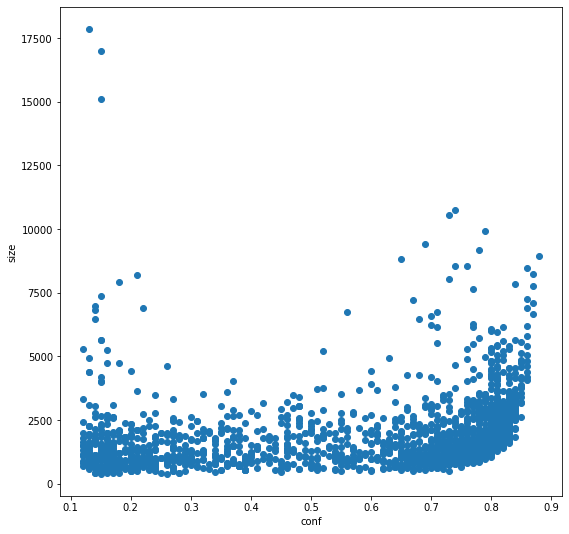

In [53]:
plt.subplots(1,1,figsize=(9,9))
plt.scatter(confs, sizes)
plt.xlabel("conf")
plt.ylabel("size")
plt.show()

In [ ]:
pd.Series(sizes).describe()

In [ ]:
pd.Series(sizes).quantile(0.9)

In [ ]:
pd.Series(gt_sizes).describe()

In [92]:
basic_cols = ['video_id', 'sequence', 'video_frame', 'sequence_frame', 'image_id',
       'annotations', 'fold', 'old_image_path', 'image_path', 'label_path',
       'real_bbox', 'num_bbox']
basic_cols = basic_cols + ['notrack_pred']
util.save_pickle(df_oof[basic_cols],"../input/wbf_notrack_pred.pkl")

In [ ]:
df_oof.columns

# check image

In [ ]:
check_versions = ["wbf"]
f2_score_df.loc[check_versions[:-1]].style.format("{:.3f}").background_gradient(axis=0)

In [ ]:
df_oof['tp'] = 0
df_oof['fp'] = 0
df_oof['fn'] = 0
for key in check_versions: 
    df_oof[f'{key}_tp'] = df_oof[f'{key}_tps'].apply(np.sum)
    df_oof[f'{key}_fp'] = df_oof[f'{key}_fps'].apply(np.sum)
    df_oof[f'{key}_fn'] = df_oof[f'{key}_fns'].apply(np.sum)
    df_oof['tp'] = df_oof['tp'] + df_oof[f'{key}_tp']
    df_oof['fp'] = df_oof['fp'] + df_oof[f'{key}_fp']
    df_oof['fn'] = df_oof['fn'] + df_oof[f'{key}_fn']

In [ ]:
color_pred = [(0,125,0)]    
color_real = [(255,0,0)]
def plot_img(df, idx, keys, save=False, pre=""):
    row = df.iloc[idx]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    real_bboxes = row["real_bbox"]
    preds = row["track_pred"]
#     for key in keys:
#         best_conf = best_conf_dict[key]
#         pred_col = "pred_" + key + "_fold1"
#         if len(row[pred_col]) > 0:
#             preds = preds + [p for p in row[pred_col] if p[0] >= best_conf]
            
    bboxes = [p[1:5] for p in preds]
    confis = [p[0] for p in preds]
    print(f"video {row.video_id}, sequence {row.sequence}, frame {row.video_frame}")
    img_plot = util.show_img(img, 
                          bboxes + real_bboxes, 
                          confis + [1] * len(real_bboxes),
                          color_pred  * len(bboxes) + color_real * len(real_bboxes), 
                          bbox_format='coco')
    if save:
        img_plot.save(f"./pic_check/{pre}v{row.video_id}_frame{row.video_frame}_seq{row.sequence}.jpg")
    display(img_plot)

In [ ]:
for i, iou in tqdm(enumerate(np.arange(0.3,0.85,0.05))):
    df_oof[f"f2_{iou:.2f}"] = 0
    df_oof[f"P_{iou:.2f}"] = 0
    df_oof[f"R_{iou:.2f}"] = 0
    for idx in df_oof.index:
        tp = 0
        fp = 0
        fn = 0
        for key in check_versions:
            tp += df_oof.loc[idx, f'{key}_tps'][i]
            fp += df_oof.loc[idx, f'{key}_fps'][i]
            fn += df_oof.loc[idx, f'{key}_fns'][i]
        df_oof.loc[idx, f"f2_{iou:.2f}"] = util.f_beta(tp, fp, fn, beta=2)
        df_oof.loc[idx, f"P_{iou:.2f}"] = util.f_beta(tp, fp, fn, beta=0)
        df_oof.loc[idx, f"R_{iou:.2f}"] = util.f_beta(tp, fp, fn, beta=100)

In [ ]:
df_oof["f2"] = df_oof[[f'f2_{iou:.2f}' for iou in np.arange(0.3,0.85,0.5)]].mean(axis=1)
df_oof["P"] = df_oof[[f'P_{iou:.2f}' for iou in np.arange(0.3,0.85,0.5)]].mean(axis=1)
df_oof["R"] = df_oof[[f'R_{iou:.2f}' for iou in np.arange(0.3,0.85,0.5)]].mean(axis=1)
#df_oof.head()

In [ ]:
show_col = ["video_id","sequence","video_frame","num_bbox", "f2", "P", "R"]
sub_col = ["fp"] + [key+"_fp" for key in check_versions]
sub_col = sub_col + ["tp"] + [key+"_tp" for key in check_versions]
sub_col = sub_col + ["fn"] + [key+"_fn" for key in check_versions]

## most FP among empy group

In [ ]:
df_neg = df_oof.query("num_bbox == 0").copy()
df_neg.sort_values("fp", ascending=False, inplace=True)
df_neg.reset_index(inplace=True, drop=True)
df_neg[show_col + sub_col].head()

In [ ]:
for i in range(5):
    plot_img(df_neg, i, model_versions, save=False)

## Most FP among non-empty group

In [ ]:
df_pos = df_oof.query("num_bbox > 0").copy()
df_pos.sort_values("fp", ascending=False, inplace=True)
df_pos.reset_index(inplace=True, drop=True)
df_pos[show_col + sub_col].head()

In [ ]:
for i in range(5):
    plot_img(df_pos, i, model_versions)

## Most TP

In [ ]:
df_pos = df_oof.query("num_bbox > 0").copy()
df_pos.sort_values("tp", ascending=False, inplace=True)
df_pos.reset_index(inplace=True, drop=True)
df_pos[show_col + sub_col].head(5)

In [ ]:
for i in range(3):
    plot_img(df_pos, i, model_versions)

## Most FN

In [ ]:
df_pos = df_oof.query("num_bbox > 0").copy()
df_pos.sort_values("fn", ascending=False, inplace=True)
df_pos.reset_index(inplace=True, drop=True)
df_pos[show_col + sub_col].head(10)

In [ ]:
for i in range(10):
    plot_img(df_pos, i, model_versions)

# Make Video

In [ ]:
df_oof.groupby(["video_id","sequence"]).size()

In [ ]:
from IPython.display import Image
from PIL import Image as Img
import subprocess
#This code I found in: https://www.kaggle.com/bamps53/create-annotated-video Thank you for sharing.
out_dir = "/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/video_check/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def load_image(image_dir):
    assert os.path.exists(image_dir), f'{image_dir} does not exist.'
    img = cv2.imread(str(image_dir))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_image_with_annotations(image_dir, annotations):
    img = load_image(image_dir)
    if len(annotations) > 0:
        for ann in annotations:
            cv2.rectangle(img, (ann['x'], ann['y']),
                (ann['x'] + ann['width'], ann['y'] + ann['height']),
                (0, 255, 0), thickness=2,)
    return img

def show_prediction(img, bboxes, scores, show = True):
    colors = [(0, 0, 255)]

    obj_names = ["s"]

    for box, score in zip(bboxes, scores):
        cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), (255,0,0), 2)
        cv2.putText(img, f'{score:.2f}', (int(box[0]), int(box[1])-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2, cv2.LINE_AA)
    if show:
        img = Img.fromarray(img).resize((1280, 720))
    return img

def make_video(df, video_id, sequence_id, pred_col, out_dir, best_conf, name=None, s_f=None, e_f=None):
    fps = 15
    width = 1280
    height = 720
    if name is None:
        name = "video"
    
    save_path = f'{out_dir}/{name}.mp4'
    tmp_path =  f'{out_dir}/tmp-{name}.mp4'
    output_video = cv2.VideoWriter(tmp_path, cv2.VideoWriter_fourcc(*"MP4V"), fps, (width, height),)
    
    # I just generate ony part of video
    if video_id is not None and sequence_id is not None:
        query = 'video_id == {} and sequence == {}'.format(video_id, sequence_id)
        if s_f is not None:
            query = query + 'and video_frame >= {} and video_frame <= {}'.format(s_f, e_f)
        print(query)
        video_df = df.query(query)
    else:
        video_df = df
    print(video_df.shape)
    for _, row in tqdm(video_df.iterrows(), total=len(video_df)):
        video_id = row.video_id
        video_frame = row.video_frame
        annotations = row.annotations
        img_file = row.image_path
        img = load_image_with_annotations(img_file, annotations)
        preds = row[pred_col]
        best_conf = 0
        bboxes = [preds[i][1:] for i in range(len(preds)) if preds[i][0] >= best_conf]
        confis = [preds[i][0] for i in range(len(preds)) if preds[i][0] >= best_conf]        
        img = show_prediction(img, bboxes, confis, show=False)
        cv2.putText(img, f'{video_id}-{video_frame}', (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        output_video.write(img)
    
    output_video.release()

    if os.path.exists(save_path):
        os.remove(save_path)
    subprocess.run(
        ["ffmpeg", "-i", tmp_path, "-crf", "18", "-preset", "veryfast", "-vcodec", "libx264", save_path]
    )
    os.remove(tmp_path)

In [ ]:
for video_id, sequence in df_oof.groupby(["video_id","sequence"]).size().index:
    name = f'wbf-{video_id}-{sequence}'
    make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name)

In [ ]:
from base64 import b64encode
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1280 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
video_id = 1
sequence = 15827
s_f = 2148
e_f = 2205
q = f"video_id == {video_id} and sequence == {sequence} and video_frame >= {s_f} and video_frame <= {e_f}"
df_oof_check = df_oof.reset_index(drop=True).query(q).copy()

In [ ]:
df_oof_check.index

In [ ]:
f2_dict = util.calc_f2_score(gt_bboxs_list, prd_wbf_list, verbose=False) 
f2_dict['f2']

In [ ]:
gt_bboxs_list_modify = gt_bboxs_list.copy()
prd_wbf_list_modify = prd_wbf_list.copy()

In [ ]:
# for idx in df_oof_check.index:
#     prd_wbf_list_modify[idx] = np.array([])
for idx in df_oof_check.index:
    pred = prd_wbf_list_modify[idx]
    if len(pred) > 0:
        gt_bboxs_list_modify[idx] = pred[:,1:]

In [ ]:
# for idx in df_oof_check.index:
#     print(gt_bboxs_list_modify[idx])

In [ ]:
prd_wbf_list_modify[idx]

In [ ]:
f2_dict = util.calc_f2_score(gt_bboxs_list_modify, prd_wbf_list_modify, verbose=False) 
f2_dict['f2']

In [ ]:
(df_oof_check['track_pred'].apply(len) > 0).sum()

In [ ]:
video_id = 2
sequence =26651
s_f =4154
e_f =4200

name = f'UnkownFP_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

In [ ]:
df_oof['track_pred']

In [ ]:
video_id = 2
sequence =26651
s_f =4639
e_f =4748

name = f'FP_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

In [ ]:
video_id = 2
sequence =26651
s_f =5024
e_f =5090

name = f'Fish_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

In [ ]:
video_id = 2
sequence =26651
s_f =5120
e_f =5160

name = f'Fish_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

# Improve FN

In [ ]:
egs = [
    # sequence , frame id
    (53708, 8926),
    (53708, 8928),
    (53708, 9654),
    (53708, 9655),
]

In [ ]:

def plot_img_2(df, sequence, frame_id, keys, save=False, pre="", use_clahe=False, aug=None):
    #row = df.iloc[idx]
    row = df.query("sequence == @seq and video_frame == @frame_id").iloc[0]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    if use_clahe:
        for i in range(3):
            img[:, :, i] = clahe.apply((img[:, :, i]))         
    if aug is not None:
        img = aug(image=img)['image']
    real_bboxes = row["real_bbox"]
    preds = row["track_pred"]            
    bboxes = [p[1:5] for p in preds]
    confis = [p[0] for p in preds]
    print(f"video {row.video_id}, sequence {row.sequence}, frame {row.video_frame}")
    img_plot = util.show_img(img, 
                          bboxes + real_bboxes, 
                          confis + [1] * len(real_bboxes),
                          color_pred  * len(bboxes) + color_real * len(real_bboxes), 
                          bbox_format='coco')
    if save:
        img_plot.save(f"./pic_check/{pre}v{row.video_id}_frame{row.video_frame}_seq{row.sequence}.jpg")
    display(img_plot)

In [ ]:
seq, frame = egs[0]
seq_tp = 53708
frame_tp = 9653
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=False)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=False)

## CLAHE

In [ ]:
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10, 10))
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=True)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=True)        

## HueSaturationValue

In [ ]:
aug = A.HueSaturationValue(hue_shift_limit=10,p = 1.0)
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=False, aug=aug)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=False, aug=aug)        

## RGBShift

In [ ]:
aug = A.RGBShift(r_shift_limit = 40, b_shift_limit=0, g_shift_limit=0, p = 1.0)
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=False, aug=aug)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=False, aug=aug)        

## FUnIE-GAN

In [ ]:
sys.path.append("./FUnIE-GAN/PyTorch/")
from nets import funiegan

model_path = "./FUnIE-GAN/PyTorch/models/funie_generator.pth"
model = funiegan.GeneratorFunieGAN()
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

In [ ]:
model.eval()

In [ ]:
import torchvision.transforms as transforms
## data pipeline
img_width, img_height, channels = 1280, 1280, 3
transforms_ = [transforms.Resize((img_height, img_width), transforms.InterpolationMode.BICUBIC),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
transform = transforms.Compose(transforms_)

In [ ]:
path = df_oof.query("sequence == 53708 and video_frame == 8926").iloc[0]["image_path"]
path = df_oof.query("sequence == 53708 and video_frame == 9653").iloc[0]["image_path"]

In [ ]:
from PIL import Image
from torch.autograd import Variable
import torch
Tensor = torch.FloatTensor 
#path = '../../data/tensorflow-great-barrier-reef/train_images/video_0/8926.jpg'
inp_img = transform(Image.open(path))
inp_img = Variable(inp_img).type(Tensor).unsqueeze(0)
gen_img = model(inp_img)

In [ ]:
from torchvision.utils import save_image

In [ ]:
save_image(gen_img, "./test2.jpg", normalize=True)

In [ ]:
plt.imshow(gen_img.squeeze().data.permute(1, 2, 0).numpy())